In [1]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
from sklearn.metrics import roc_curve,roc_auc_score

In [4]:
from DataGenerator import load_data
from Flops import get_flops

In [5]:
#推測是CPU跑
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [6]:
# 模型參數設定
# MobileNetV3Large 、 MobileNetV3Small 、 CustomizeLarge 、 CustomizeSmall 
backbone = 'CustomizeSmall'
# SE CBAM CA
Attention_block_1 = None
Attention_block_2 = 'SE'
# Adam RMSprop CLR
LR_mode = 'Adam'

In [7]:
# 100 Bird Species  or  325 Bird Species  or  cifar100  or  cifar10
Dataset = "325 Bird Species"
BATCH_SIZE = 1

if Dataset == "325 Bird Species":
    dir = "./Dataset/325 Bird Species/"
    input_shape = (224,224,3)
    num_classes = 325
    trainset, valset, testset = load_data(Dataset, dir, input_shape, BATCH_SIZE)
    
elif Dataset == "100 Bird Species":
    dir = "./Dataset/100 Bird Species/"
    input_shape = (224,224,3)
    num_classes = 100
    trainset, valset, testset = load_data(Dataset, dir, input_shape, BATCH_SIZE)
    
elif Dataset == "cifar100":
    input_shape = (32,32,3)
    num_classes = 100
    datagen_train, datagen_val, x_train, y_train, x_val, y_val, x_test, y_test = load_data(Dataset, '', input_shape, num_classes)
    x_train = x_train/255
    x_val = x_val/255
    x_test =x_test/255
    
elif Dataset == "cifar10":
    input_shape = (32,32,3)
    num_classes = 10
    datagen_train, datagen_val, x_train, y_train, x_val, y_val, x_test, y_test= load_data(Dataset, '', input_shape, num_classes)
    x_train = x_train/255
    x_val = x_val/255
    x_test =x_test/255

Found 47332 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.


In [8]:
if Dataset[:5] == 'cifar':
    test_generator = x_test
    Y_true = y_test
    print(np.shape(Y_true))
    y_true = np.argmax(Y_true, axis=1)
    stepNum=len(test_generator)
    print("stepNum",stepNum)
else:
    # 利用ImageDataGenerator將test樣本讀進來
    datagen_test = ImageDataGenerator(rescale= 1/255,)

    test_generator = datagen_test.flow_from_directory(dir + 'test',
                                                    target_size=(224,224),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False
                                                    )
    y_true = test_generator.labels
    
    # test_generator = testset
    # y_true = test_generator.labels
    
    stepNum=len(y_true)
    print("stepNum",stepNum)

Found 1625 images belonging to 325 classes.
stepNum 1625


In [9]:
model_dir = './weights/{0}/{1}_{2}_{3}/best_model'.format(backbone, Attention_block_2, LR_mode, Dataset)
print(model_dir)
model = tf.keras.models.load_model(model_dir)

./weights/CustomizeSmall/SE_Adam_325 Bird Species/best_model


In [10]:
model.summary()
print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['Conv1[0][0]']                  
 alization)                     )                                                           

In [11]:
# results = model.evaluate(x_test, y_test, batch_size=256)
# print("test loss, test acc:", results)

In [12]:
import time

mean_FPS=0
for i in range(5):
    start = time.time()

    #利用模型進行預測，記得輸入的test_generator的shuffle內建要是False
    Y_pred = model.predict(test_generator,steps=stepNum)

    end = time.time()

    # Time elapsed
    seconds = end - start
    FPS = stepNum/seconds
    if i==0:
        continue
    mean_FPS+=FPS
    # print("FPS:",FPS)
mean_FPS /= 4
print('Mean FPS:',mean_FPS)

Mean FPS: 125.96139588927296


In [13]:
#預測值。假設有2類，則上述回傳值Y_pred目前是一個40x2(test樣本數x類別數)的矩陣
print('Y_pred',Y_pred)#預測分數
print('Y_pred.shape',Y_pred.shape)
print('-'*100)

#分類結果，即每個樣本的判斷結果是什麼。例如兩個類別，y_pred就是0與1，且y_pred是(28,)(test樣本數,)的矩陣
y_pred = np.argmax(Y_pred, axis=1)
print('y_pred=',y_pred)
print('y_pred.shape',y_pred.shape)
print('-'*100)

print('y_true=',y_true)
print('y_true.shape',y_true.shape)

Y_pred [[9.20299292e-01 4.78391557e-05 7.07376385e-05 ... 1.29092396e-05
  1.22222744e-04 1.08220062e-04]
 [9.06100035e-01 3.67846951e-05 1.84835037e-04 ... 1.53148521e-05
  6.98531745e-04 1.49005104e-03]
 [8.73585463e-01 5.21725233e-05 2.97003717e-04 ... 5.63402791e-05
  5.45937277e-04 2.31905200e-04]
 ...
 [9.81535850e-05 3.73377006e-05 8.00644048e-05 ... 1.03897888e-04
  1.37964124e-03 9.37510312e-01]
 [2.24572793e-03 3.89430876e-04 2.75916886e-04 ... 8.71523400e-04
  8.40209483e-04 3.63567442e-01]
 [1.16208066e-04 5.31217411e-05 6.46144836e-05 ... 2.76744395e-04
  4.80491057e-04 9.26837087e-01]]
Y_pred.shape (1625, 325)
----------------------------------------------------------------------------------------------------
y_pred= [  0   0   0 ... 324 324 324]
y_pred.shape (1625,)
----------------------------------------------------------------------------------------------------
y_true= [  0   0   0 ... 324 324 324]
y_true.shape (1625,)


In [14]:
# Name of all classes in CIFAR-100
if Dataset=='cifar100':
    classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
    'aquarium' ,'fish', 'ray', 'shark', 'trout', 
    'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
    'bottles', 'bowls', 'cans', 'cups', 'plates', 
    'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
    'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
    'bear', 'leopard', 'lion', 'tiger', 'wolf', 
    'bridge', 'castle', 'house', 'road', 'skyscraper', 
    'cloud', 'forest', 'mountain', 'plain', 'sea', 
    'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
    'crab', 'lobster', 'snail', 'spider', 'worm', 
    'baby', 'boy', 'girl', 'man', 'woman', 
    'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
    'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
    'maple', 'oak', 'palm', 'pine', 'willow', 
    'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
    'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
elif Dataset == "cifar10":
    classes = ["airplane", "automobile", "bird", "cat",
               "deer", "dog", "frog", "horse", "ship", "truck"]
else:
    classes =[]
for i in classes:
    print(i)

confusion_matrix:
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]


C:\Users\user\AppData\Local\Temp\ipykernel_13768\2455521637.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
C:\Users\user\AppData\Local\Temp\ipykernel_13768\2455521637.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


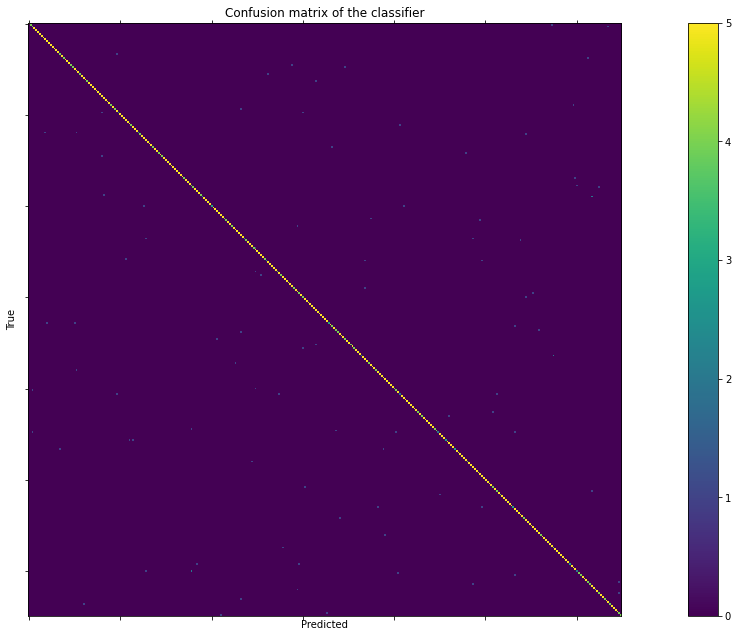

In [15]:
#test_generator.classes為實際28張測試樣本的label，y_pred為預測的label
# confusion_matrixRet=confusion_matrix(y_true=y_true,y_pred= y_pred)
confusion_matrixRet=confusion_matrix(y_true = y_true, y_pred= y_pred)
print('confusion_matrix:')
print(confusion_matrixRet)

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(confusion_matrixRet)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# DF = pd.DataFrame(confusion_matrixRet, columns=classes, index=classes)
DF = pd.DataFrame(confusion_matrixRet)
DF
# DF.to_csv('confusion_matrix.csv')

,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [17]:
#classification_report, 可以自動算出precision,recall與f1-score
# target_name = ['covid_19', 'lungopacity', 'normal', 'viralpneumonia']
classification_reports = classification_report(y_true = y_true,
                                              y_pred= y_pred,
                                              # target_names=target_name,
                                              output_dict=True
                                             )
# print(classification_report)#會輸出precision、recall與f1-score。

In [18]:
Dict =  classification_reports
Col = []
for i in Dict:
    Col.append(i)

precision=[]
recall=[]
f1_score=[]
support=[]

for i in Col:
    if i == 'accuracy':
        precision.append('')
        recall.append('')
        f1_score.append(Dict[i])
        support.append('')
    else:
        precision.append(Dict[i]['precision'])
        recall.append(Dict[i]['recall'])
        f1_score.append(Dict[i]['f1-score'])
        support.append(Dict[i]['support'])  

Data = {'precision':precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support}

DF = pd.DataFrame(Data,index=Col)
# DF.to_csv("Accuracy.csv")
DF

,precision,recall,f1-score,support
0,1.0,1.0,1.000000,5
1,1.0,0.8,0.888889,5
2,0.666667,0.8,0.727273,5
3,1.0,1.0,1.000000,5
4,1.0,1.0,1.000000,5
...,...,...,...,...
323,0.666667,0.8,0.727273,5
324,1.0,0.8,0.888889,5
accuracy,,,0.942154,
macro avg,0.952967,0.942154,0.941233,1625
